# Boxplots

## Script setup

In [66]:
# Third-party and standard modules
from typing import Optional
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import pytz
from itertools import repeat
from importlib import reload

# User-defined modules.
# The reload() function is needed to update modules after
# changes are made to their files.
from modules import dataframe_manip as dfm
from modules import misc, schemas, College1AcPtTimeSeries
# The reload() function is needed to update modules after
# changes are made to their files.
dfm = reload(dfm)
misc = reload(misc)
schemas = reload(schemas)
College1AcPtTimeSeries = reload(College1AcPtTimeSeries)

## Script parameters

The following values are this script's parameters.

In [67]:
filepath = './cisco_wifi_data_until_20190513.csv'
timezone = pytz.timezone('US/Pacific')
schema: schemas.AcPtTimeSeries =\
    College1AcPtTimeSeries.College1AcPtTimeSeries
buildings = [
    'SCC', 'HAHN', 'CROOKSHANK', 'THATHCHER', 'CLARK',
    'CARNEGIE', 'MASON', 'PEARSON', 'ALEXANDER', 'ITB'
]

## Data Processing

In [68]:
# A time-series dataframe holding occupancy counts
# for many access points (columns).
occ: pd.DataFrame = dfm.csv_to_timeseries_df(
    filepath=filepath, timezone=timezone
)

In [69]:
# Eliminate columns for access points not in the buildings we want.
occ = occ.drop(columns=list(filter(
    # add to drop-list if NOT in the buildings we want.
    lambda col: schema.col_to_building(col, safe=True) not in buildings,
    occ.columns.to_list()
)))

occ = dfm.fill_intervening_nas(
    occ, inplace=True, fill_val=0
)

In [70]:
occ_bybuild = occ.groupby(
    by=schema.col_to_building, axis=1
)

In [71]:
print('buildings not found: {}'.format(set(buildings) - set(occ_bybuild.groups.keys())))

# We can only work with the buildings we found.
buildings = list(occ_bybuild.groups.keys())

buildings not found: {'PEARSON', 'CROOKSHANK', 'THATHCHER'}


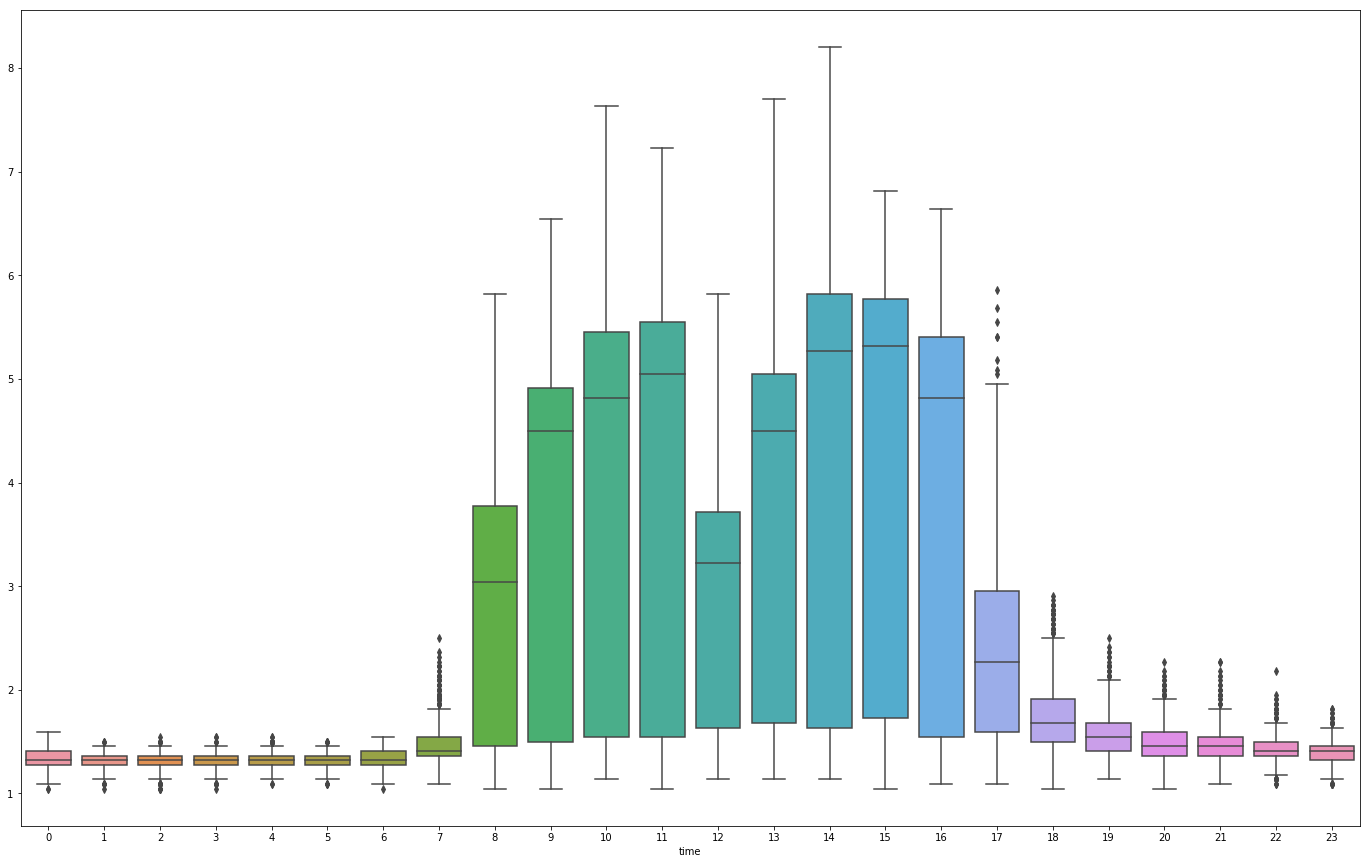

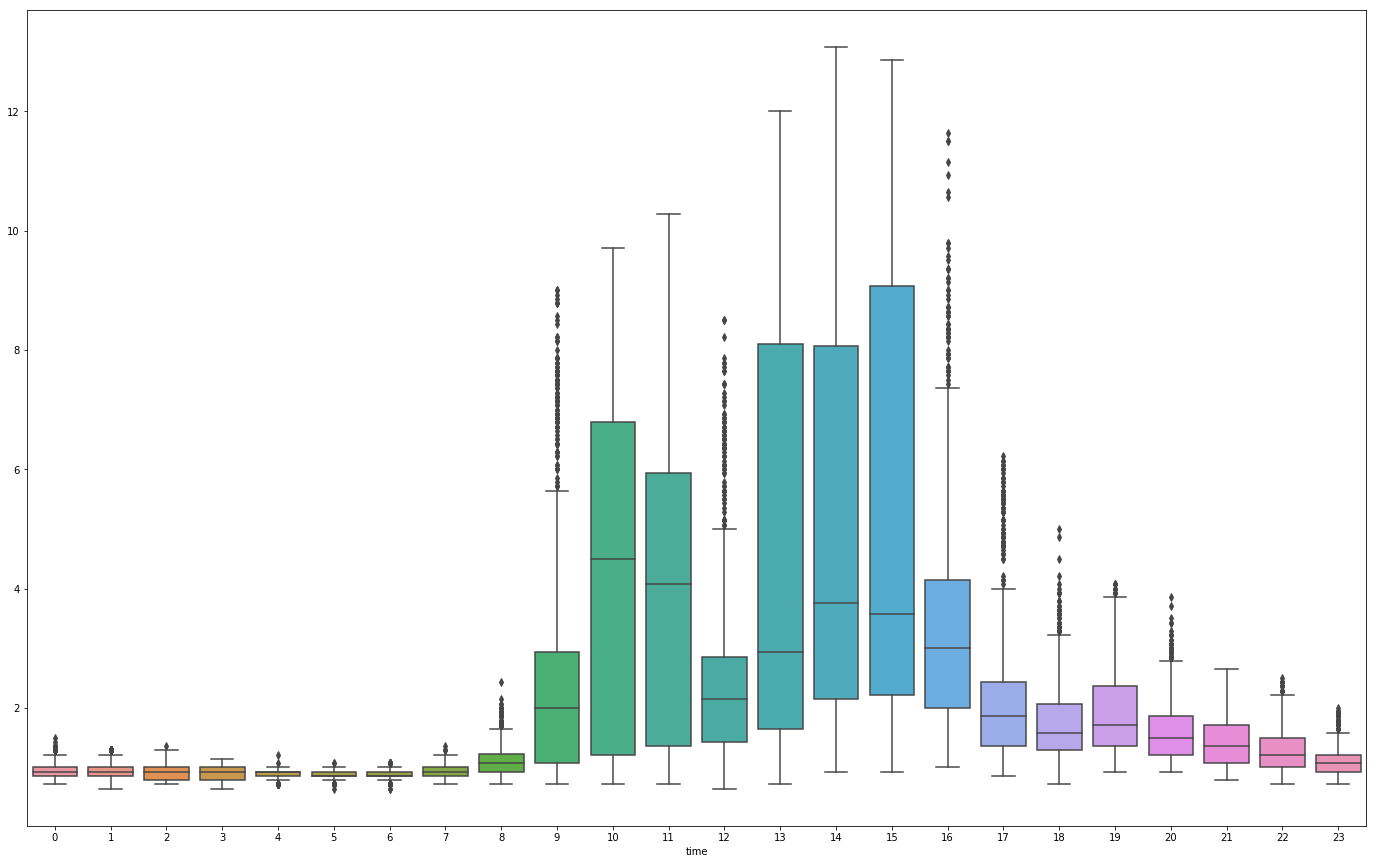

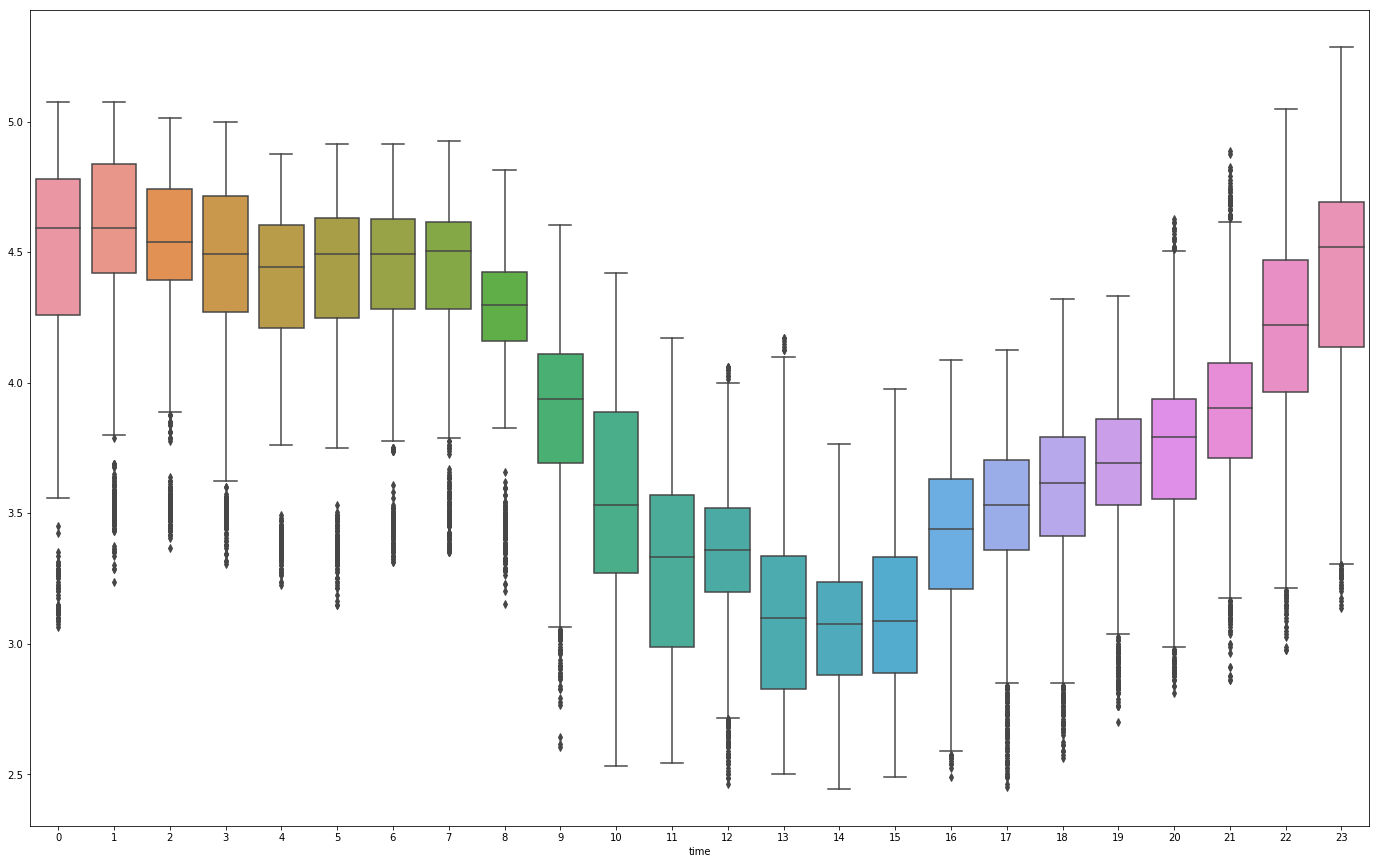

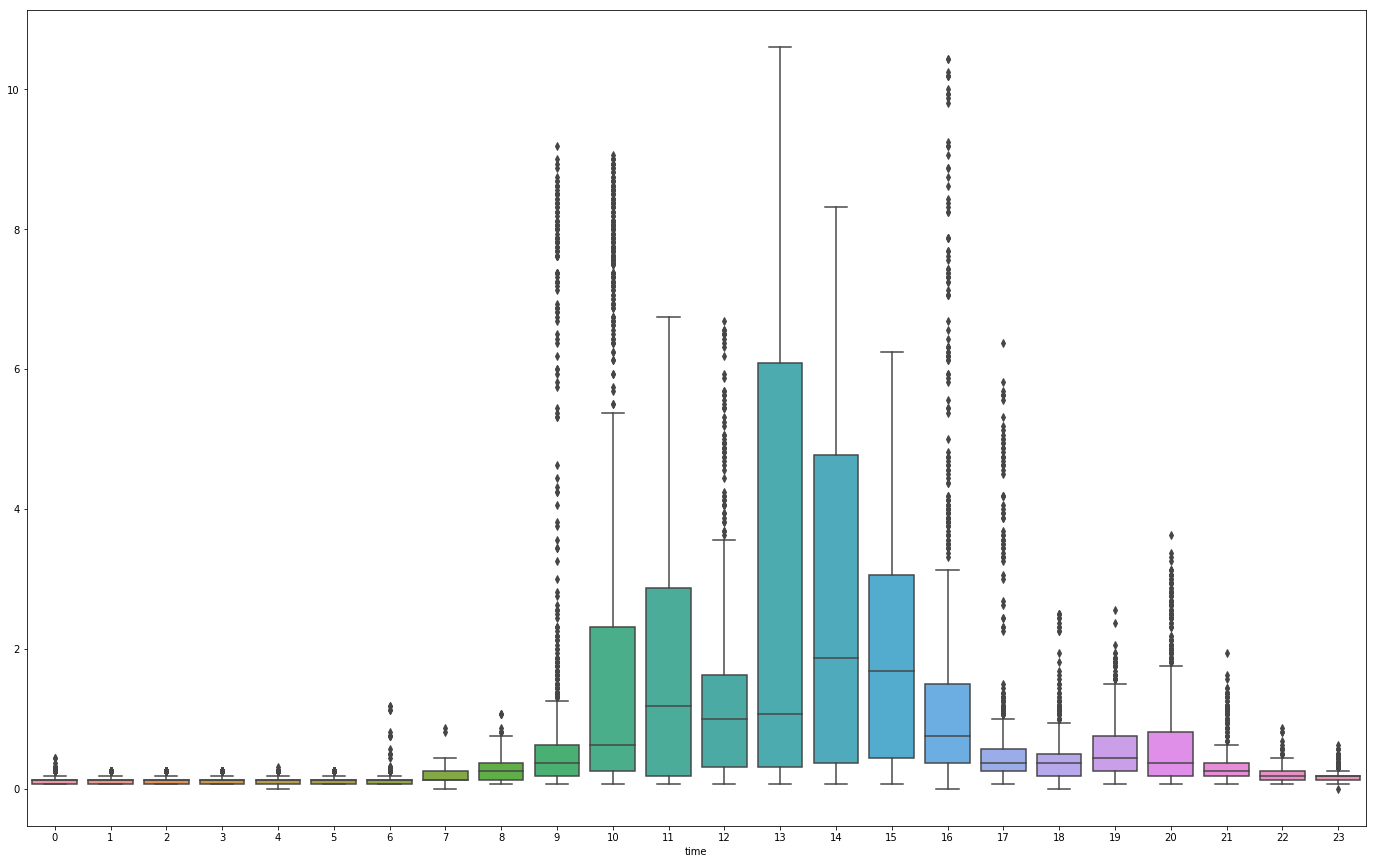

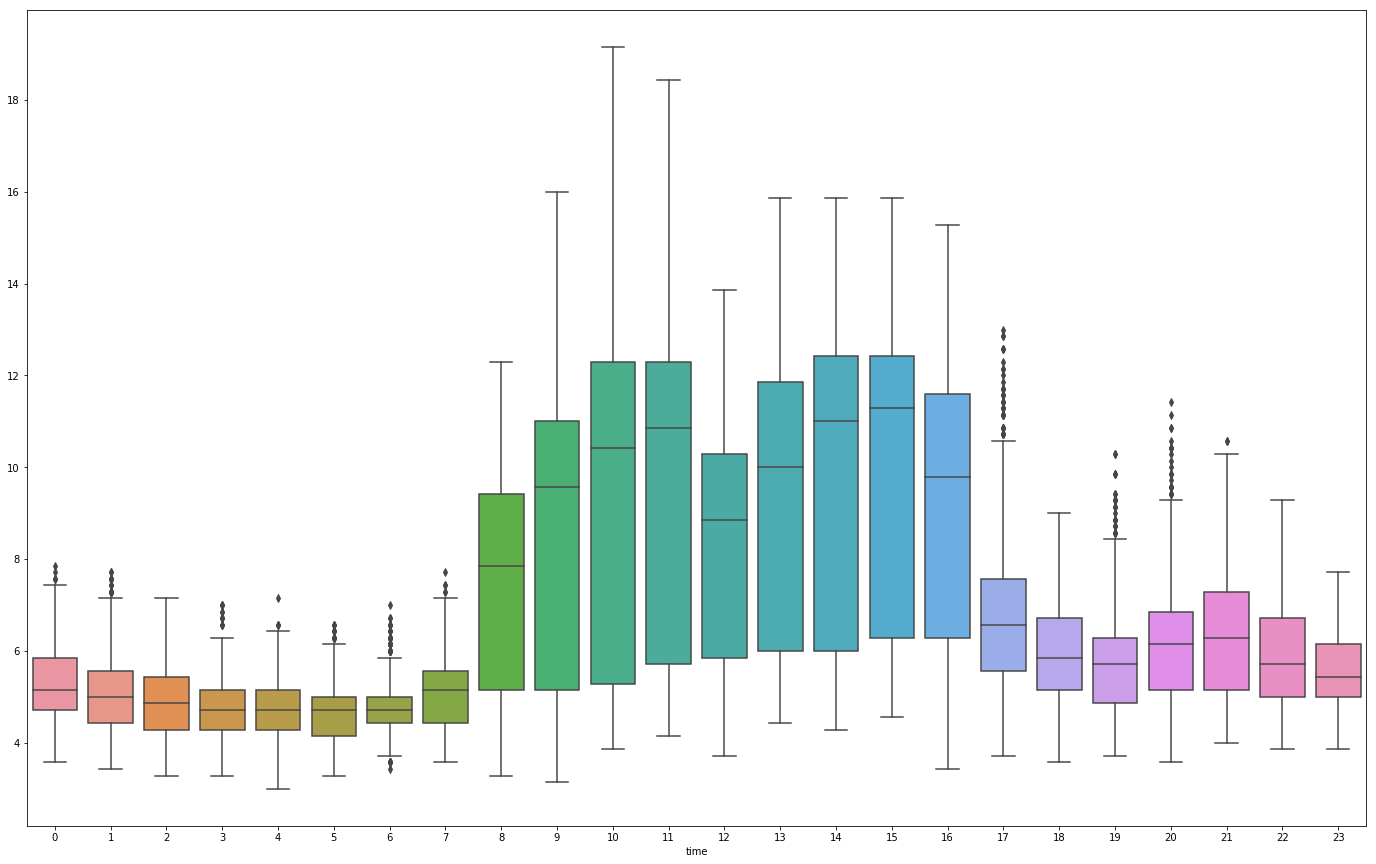

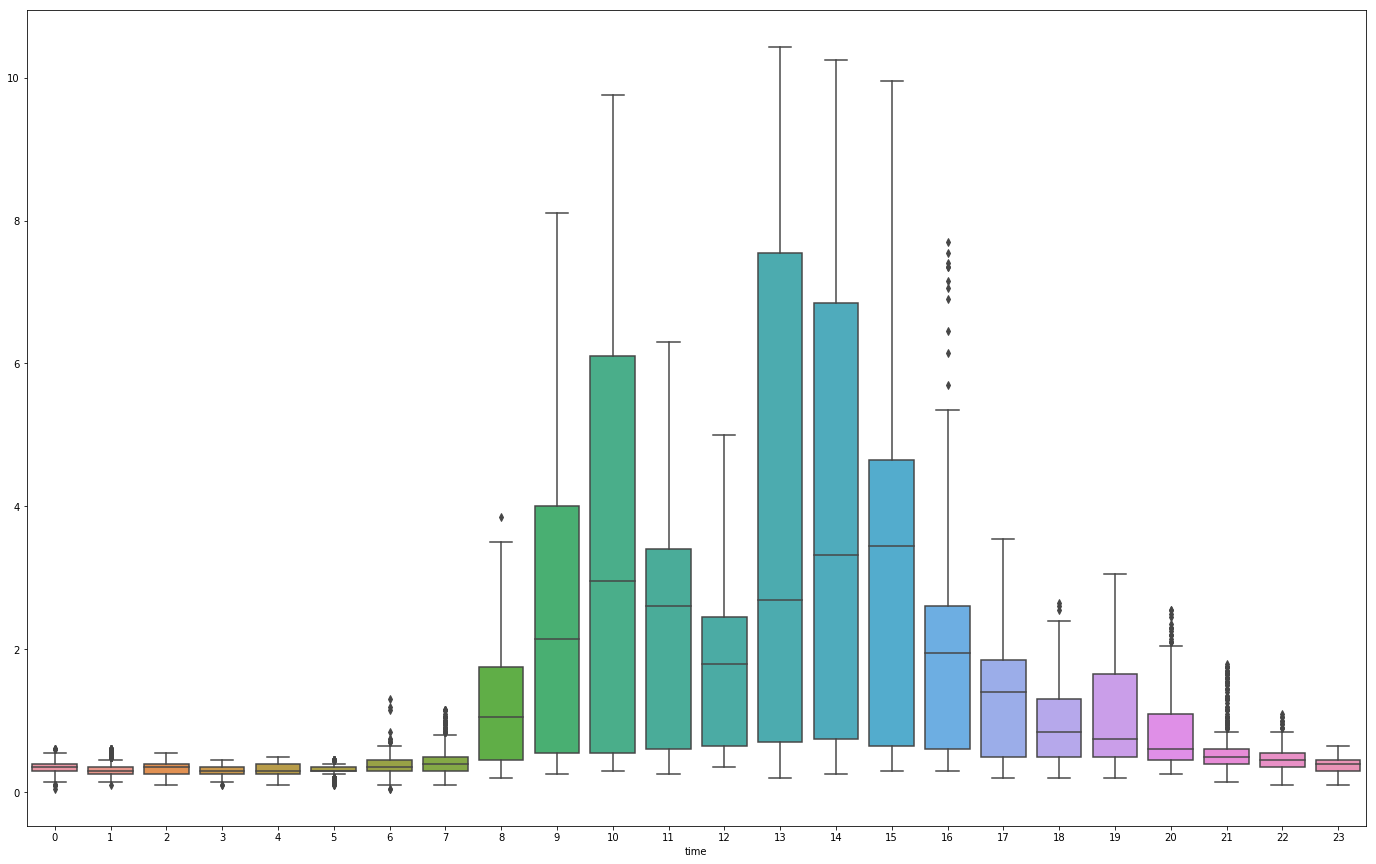

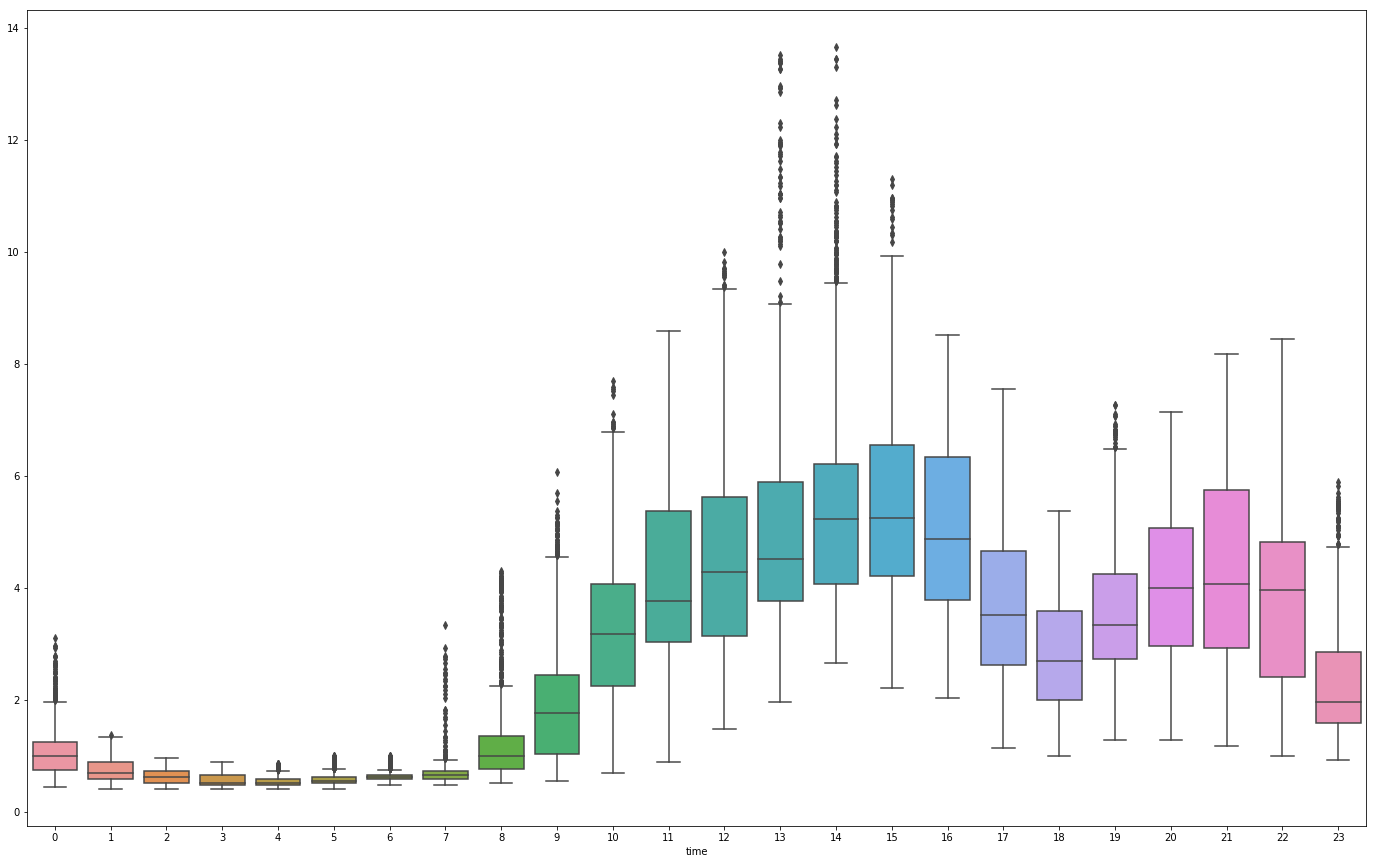

In [72]:
for name, build_occ in occ_bybuild:
    mean_occupancy: pd.DataFrame = dfm.row_means(build_occ)
    
    fig, ax = plt.subplots(figsize=(24, 15))
    ax.set_title(name)
    a
    
    seaborn.boxplot(
        # The hours (a number [0,23]) for each row.
        x=mean_occupancy.index.hour,
        # The total occupancy at that hour.
        y=mean_occupancy,
        ax=ax
    )